In [65]:
import os
import matplotlib
import numpy             as     np
import pandas            as     pd
import scipy.optimize    as     opt
import matplotlib.pyplot as     plt
from   matplotlib        import font_manager
from   fractions         import Fraction
import pickle
import warnings
import sys

def updateContForce(theta, binCentersList, forceList, contList, forceVal):
    '''
    This function is used to calulated the complementary contact angle and 
    sum-append the force for that contact to relevant list

    Inputs:
    theta          - primary contact angle. Calculated by arctan2(nz,nx)
    binCentersList - centers of bins
    forceList      - list of total forces for each bin. The force appends here at the relevant bin
    forceVal       - the value of norm of the normal contact force to be sum-appended to 'forceList'
    '''
    
    #bin_Center = int(np.floor(len(binCentersList)/2))
    bin_Center = len(binCentersList) // 2
    bin_Index  = np.argmin(np.abs(binCentersList - theta))
    forceList[bin_Index] += forceVal
    contList[bin_Index]  += 2
    
    if bin_Index != bin_Center:
        bin_Index2 = (bin_Center + 1) + bin_Index if bin_Index < bin_Center else bin_Index - (bin_Center + 1)
        forceList[bin_Index2] += forceVal
        contList[bin_Index2]  += 2

def particleSizeList(randomSeedFile, sizeRatio, npp = 1000):
    '''
    This function reads the random seed file and creates
    a list of particle sizes. The list index is the particle index.

    Inputs:
    randomSeedFile - location for the random seed file. It contains the particle index and sizes
    sizeRatio      - delta or ar for the case
    npp            - system size
    '''

    if sizeRatio == 1:
        # Painting particles randomly in two colours for monodisperse case.
        particleSize = [1]*(int(npp/2)) + [2]*(int(npp/2))
        random.shuffle(particleSize)
    else:
        particleSize = np.loadtxt(randomSeedFile, usecols = 3) # reading only column 3 which has particle size
        randomSeedFile.close()
    return particleSize

def interactionsList(interactionFile):
    '''
    This function reads the interaction file and creates a nested-list,
    each list inside contains the array of all interaction parameters for
    that timestep.

    Input: interactionFile - the location of the interaction data file
    '''

    hashCounter = 0
    temp        = []
    contactList = [] # list with interaction parameters for each element at each timestep

    fileLines = interactionFile.readlines()[27:] # skipping the comment lines
    for line in fileLines:
        if not line.split()[0] == '#':
            lineList = [float(value) for value in line.split()]
            temp.append(lineList)
        else:
            hashCounter += 1 # checking if counter reaches 7 (7 lines of comments after every timestep data)
            if hashCounter == 7: 
                contactList.append(np.array(temp))
                temp        = []
                hashCounter = 0
    interactionFile.close()
    return contactList
###########################################################
# Matplotlib rc parameters modification

plt.rcParams.update({
  "figure.max_open_warning" : 0,
  "text.usetex"             : True,
  "text.latex.preamble"     : r"\usepackage{amsmath, bm, type1cm}",  # Added \bm for bold math
  "figure.autolayout"       : True,
  "font.family"             : "STIXGeneral",
  "mathtext.fontset"        : "stix",
  "font.size"               : 8,
  "xtick.labelsize"         : 8,
  "ytick.labelsize"         : 8,
  "lines.linewidth"         : 1,
  "lines.markersize"        : 5,
})
#plt.rcParams['text.latex.preamble']= r"\usepackage{amsmath}"
matplotlib.rc('text', usetex=True)
matplotlib.rcParams['text.latex.preamble'] = r'\boldmath'

colors = ['#4a91b5', '#e68139', '#5da258', '#87629b', '#1b9e77']

In [19]:
# script for histogram of angular contacts for small-small, small-large and large-large 
# TOTAL

import os
import numpy as np
import random

#topDir      = "/media/rahul/Rahul_2TB/high_bidispersity/"
topDir      = "/Volumes/Rahul_2TB/high_bidispersity/"

ranSeedFile = "random_seed.dat"
intFile     = "int_random_seed_params_stress100r_shear.dat"
contFile    = 'contacts.txt'

run         = {500:8,1000:4,2000:2,4000:1}

ar          = [1.0, 1.4, 1.8, 2.0, 4.0]


counts = 0

def updateContAngle(theta, contList):
    contList.append(theta)
    if theta < 0:
        contList.append(np.pi - abs(theta))
    else:
        contList.append(theta - np.pi)

def angularContactsSizePairDelta(phii, sizePair, figsave = False):
    npp = 1000
    
    plt.clf()
    cmap = matplotlib.colormaps['viridis_r'] #color scheme

    off = 100

    phii = '{:.3f}'.format(phii) if len(str(phii).split('.')[1])>2 else '{:.2f}'.format(phii)
    
    for k in range(len(ar)):
        contactAngleAllRuns = []
        dataname = topDir+'NP_'+str(npp)+'/phi_'+phii+'/ar_'+str(ar[k])+'/Vr_0.5'
        if os.path.exists(dataname):
            for l in range (run[npp]):
                ranFile = open(f'{dataname}/run_{l+1}/{ranSeedFile}', 'r')

                if ar[k] == 1:
                    particleSize = [1]*(int(npp/2)) + [2]*(int(npp/2))
                    random.shuffle(particleSize)
                    #painting particles randomly in two colours for monodisperse case
                else:
                    particleSize = np.loadtxt(ranFile,usecols=3) # reading only column 3 which has particle size
                    ranFile.close()

                #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

                # reading interaction file
                # storing the interactions for each timestep in a list
                hashCounter=0
                temp=[]
                contactList=[] # list with interaction parameters for each element at each timestep

                interFile = open(f'{dataname}/run_{l+1}/{intFile}', 'r')
                fileLines = interFile.readlines()[27:] # skipping the comment lines
                for line in fileLines:
                    if not line.split()[0] == '#':
                        lineList = [float(value) for value in line.split()]
                        temp.append(lineList)
                    else:
                        hashCounter += 1 # checking if counter reaches 7 (7 lines of comments after every timestep data)
                        if hashCounter == 7: 
                            contactList.append(np.array(temp))
                            temp = []
                            hashCounter = 0
                interFile.close()

                #%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%

                contactAngleTotal = [] # total number of particles in frictional contacts
                for sampleList in contactList:
                    timeStepContactAngle = []  # index of particles in contact
                    for i in range(sampleList.shape[0]):
                        particleSize1 = particleSize[int(sampleList[i, 0])]
                        particleSize2 = particleSize[int(sampleList[i, 1])]
                        contState = int(sampleList[i, 10])
                        if contState == 2:
                            thetaRad = np.arctan2(sampleList[i, 4], sampleList[i, 2])
                            if sizePair == 'total':
                                updateContAngle(thetaRad, timeStepContactAngle)
                                plotTitle = 'Total Contacts'
                            elif sizePair == 'ss' and particleSize1 == particleSize2 == 1:
                                updateContAngle(thetaRad, timeStepContactAngle)
                                plotTitle = 'Small - Small Contacts'
                            elif sizePair == 'sl' and particleSize1 != particleSize2:
                                updateContAngle(thetaRad, timeStepContactAngle)
                                plotTitle = 'Small - Large Contacts'
                            elif sizePair == 'll' and particleSize1 == particleSize2 > 1:
                                updateContAngle(thetaRad, timeStepContactAngle)
                                plotTitle = 'Large - Large Contacts'

                    contactAngleTotal.append(timeStepContactAngle) # nested list of all contact angles

                contactAngleList = [i for sub in contactAngleTotal[off:] for i in sub]
                contactAngleAllRuns.append(contactAngleList)

        allContactAngles   = [i for sub in contactAngleAllRuns for i in sub]
        global counts
        counts, bin_edges  = np.histogram(allContactAngles, bins = 70)
        bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
        plt.plot(bin_centers, counts/len(contactAngleTotal[off:])/run[npp], 'o', markersize=3, label=r'$\delta$' + f' = {ar[k]}',color=cmap((k+1)/len(ar)))

    xticks = [-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi]
    xtick_labels = [r'$-\pi$', r'$-\pi/2$', '0', r'$\pi/2$', r'$\pi$']
    plt.xticks(xticks, xtick_labels)
    plt.title(fr"$\phi = {phii}$, {plotTitle}", fontsize=18)
    plt.xlabel('Contact Angle', fontsize=14,fontstyle='italic')
    plt.ylabel(r'$E_c$', fontsize=14,fontstyle='italic')

    plt.xticks(fontsize=12)
    plt.yticks(fontsize=12)
    plt.legend(fontsize=14)
    plt.legend(fontsize=10, labelspacing=1,borderpad=1)

    plt.grid(which='Both', alpha=0.2)

    plt.tight_layout()
    if figsave:
        figFormat=".pdf"
        fig_save_path = "/home/rahul/Dropbox (City College)/CUNY/Research/Bidisperse Project/analysis/figures/angular_Contacts"
        plt.savefig(fig_save_path+'/contactAnglesSizeDelta'+sizePair+'_NP_'+str(1000)+'_phi_'+str(phii)+figFormat, bbox_inches="tight",dpi=500)

    plt.show()

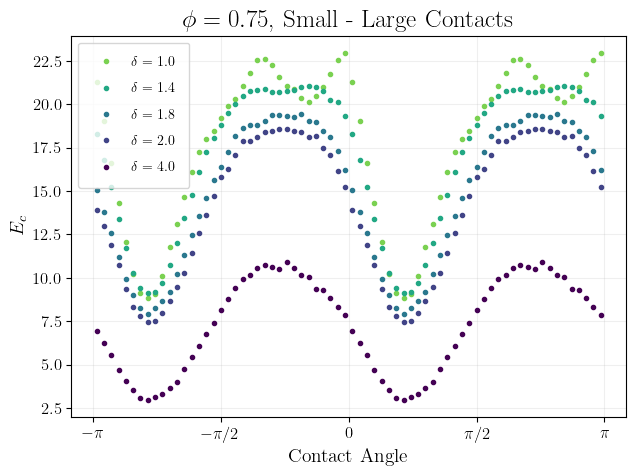

In [20]:
angularContactsSizePairDelta(0.75, 'sl', figsave = False)

In [6]:
def updateContAngle(theta, contList):
    '''
    This function to calulated the complementary contact angle and append to 
    relevant list (contList)

    Inputs:
    theta    - primary contact angle. Calculated by arctan2(nz,nx)
    contList - list where the angle appends. This list contains all the contact angle for one case, all runs
    '''
    contList.append(theta)
    if theta < 0:
        contList.append(np.pi - abs(theta))
    else:
        contList.append(theta - np.pi)

def particleSizeList(randomSeedFile, sizeRatio, npp = 1000):
    '''
    This function reads the random seed file and creates
    a list of particle sizes. The list index is the particle index.

    Inputs:
    randomSeedFile - location for the random seed file. It contains the particle index and sizes
    sizeRatio      - delta or ar for the case
    npp            - system size
    '''

    if sizeRatio == 1:
        # Painting particles randomly in two colours for monodisperse case.
        particleSize = [1]*(int(npp/2)) + [2]*(int(npp/2))
        random.shuffle(particleSize)
    else:
        particleSize = np.loadtxt(randomSeedFile, usecols = 3) # reading only column 3 which has particle size
        randomSeedFile.close()
    return particleSize

def interactionsList(interactionFile):
    '''
    This function reads the interaction file and creates a nested-list,
    each list inside contains the array of all interaction parameters for
    that timestep.

    Input: interactionFile - the location of the interaction data file
    '''

    hashCounter = 0
    temp        = []
    contactList = [] # list with interaction parameters for each element at each timestep

    fileLines = interactionFile.readlines()[27:] # skipping the comment lines
    for line in fileLines:
        if not line.split()[0] == '#':
            lineList = [float(value) for value in line.split()]
            temp.append(lineList)
        else:
            hashCounter += 1 # checking if counter reaches 7 (7 lines of comments after every timestep data)
            if hashCounter == 7: 
                contactList.append(np.array(temp))
                temp        = []
                hashCounter = 0
    interactionFile.close()
    return contactList  

In [22]:
def updateContForce(theta, binCentersList, forceList, forceVal):
    '''
    This function is used to calulated the complementary contact angle and 
    sum-append the force for that contact to relevant list

    Inputs:
    theta          - primary contact angle. Calculated by arctan2(nz,nx)
    binCentersList - centers of bins
    forceList      - list of total forces for each bin. The force appends here at the relevant bin
    forceVal       - the value of norm of the normal contact force to be sum-appended to 'forceList'
    '''
    
    bin_Index = np.argmin(np.abs(binCentersList - theta))
    forceList[bin_Index] += forceVal
    if theta < 0:
        theta2    = np.pi - abs(theta)
        bin_Index = np.argmin(np.abs(binCentersList - theta2))
    else:
        theta2    = theta - np.pi
        bin_Index = np.argmin(np.abs(binCentersList - theta2))
    forceList[bin_Index] += forceVal

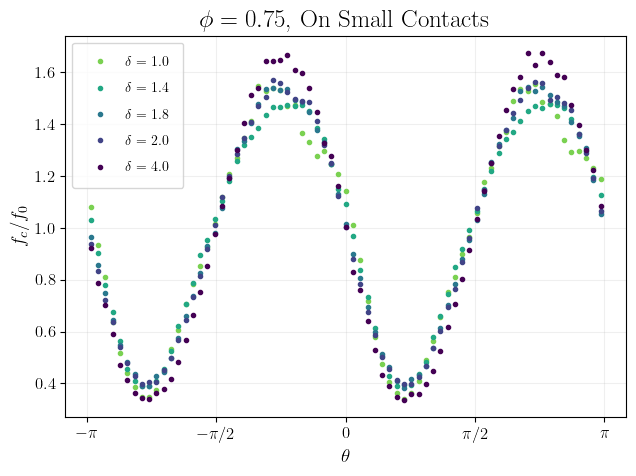

In [24]:
#def angularContactsOnSize(phii, onSize, figsave = False):
'''
This function is for plotting histogram of contact angles for a size pair small-small/ small-large/ large-large 
for one phi value.
Plots would be Ec vs theta, will contain curves for all ar values for a single size pair

Inputs:
phii     - phi value
sizePair - can be one of the following strings: 'total', 'ss', 'sl' or 'll'
'''
plt.clf()
cmap = matplotlib.colormaps['viridis_r'] #color scheme

phii = 0.75
onSize = 'onsmall'

npp = 1000
off = 100

'''
This function is for plotting histogram of contact angles for a size pair small-small/ small-large/ large-large 
for one phi value.
Plots would be Ec vs theta, will contain curves for all ar values for a single size pair

Inputs:
phii     - phi value
sizePair - can be one of the following strings: 'total', 'ss', 'sl' or 'll'
'''
plt.clf()
cmap = matplotlib.colormaps['viridis_r'] #color scheme

npp = 1000
off = 100

angleBins  = np.linspace(-np.pi, np.pi,72)
binCenters = (angleBins[:-1] + angleBins[1:])/2

phii = '{:.3f}'.format(phii) if len(str(phii).split('.')[1])>2 else '{:.2f}'.format(phii)

for k in range(len(ar)):
    dataname = topDir + 'NP_' + str(npp) + '/phi_' + phii + '/ar_' + str(ar[k]) + '/Vr_0.5'
    if os.path.exists(dataname):
        for l in range (1):
            ranFile      = open(f'{dataname}/run_{l+1}/{ranSeedFile}', 'r')
            particleSize = particleSizeList(ranFile, sizeRatio = ar[k])

            interFile   = open(f'{dataname}/run_{l+1}/{intFile}', 'r')
            contactList = interactionsList(interFile)

            forceBin_Sum = [0]*len(binCenters) # Total number of particles in frictional contacts
            contCount    = 0
            for sampleList in contactList[off:]:
                for i in range(sampleList.shape[0]):
                    particleSize1 = particleSize[int(sampleList[i, 0])]
                    particleSize2 = particleSize[int(sampleList[i, 1])]
                    contForce     = sampleList[i,11] # Norm of normal contact force
                    contState     = int(sampleList[i, 10]) # Contact state

                    if contState == 2:
                        thetaRad = np.arctan2(sampleList[i, 4], sampleList[i, 2])
                        if onSize   == 'onsmall' and (particleSize1 == 1 or particleSize2 == 1):
                            updateContForce(thetaRad, binCenters, forceBin_Sum, contForce)
                            contCount += 2
                            plotTitle = 'On Small Contacts'

                        elif onSize == 'onlarge' and (particleSize1 > 1 or particleSize2 > 1):
                            updateContForce(thetaRad, binCenters, forceBin_Sum, contForce)
                            contCount += 2
                            plotTitle = 'On Large Contacts'

    # Histogram plotting
    forceAvg     = np.mean(forceBin_Sum)
    forceDensity = [i/forceAvg for i in forceBin_Sum]
    plt.plot(binCenters, forceDensity, 'o', markersize = 3, label = r'$\delta$' + f' = {ar[k]}', color = cmap((k+1)/len(ar))) 

xticks       = [-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi]
xtick_labels = [r'$-\pi$', r'$-\pi/2$', '0', r'$\pi/2$', r'$\pi$']
plt.xticks(xticks, xtick_labels)
plt.title(fr"$\phi = {phii}$, {plotTitle}", fontsize = 18)
plt.xlabel(r'$\theta$',  fontsize = 14, fontstyle = 'italic')
plt.ylabel(r'$f_c/f_0$', fontsize = 14, fontstyle = 'italic')

plt.xticks(fontsize = 12)
plt.yticks(fontsize = 12)
plt.legend(fontsize = 10, labelspacing = 1, borderpad = 1)

plt.grid(which = 'Both', alpha = 0.2)

plt.tight_layout()
if False:
    figFormat     = ".pdf"
    plt.savefig(fig_save_path+'/angularContactsSizePair_' + onSize + '_NP_' + str(1000) + '_phi_' + str(phii) + figFormat, bbox_inches = "tight", dpi = 500)

#plt.show()

[7.0, 2.0, 3.0, 1.0] 

[14.0, 7.0, 6.0, 1.0] 

[99.0, 71.0, 27.0, 1.0] 



/tmp/ipykernel_341345/2684736732.py:101: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1,j].set_xticklabels(xtick_labels, fontsize=16)
/tmp/ipykernel_341345/2684736732.py:101: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1,j].set_xticklabels(xtick_labels, fontsize=16)
/tmp/ipykernel_341345/2684736732.py:101: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1,j].set_xticklabels(xtick_labels, fontsize=16)


<Figure size 640x480 with 0 Axes>

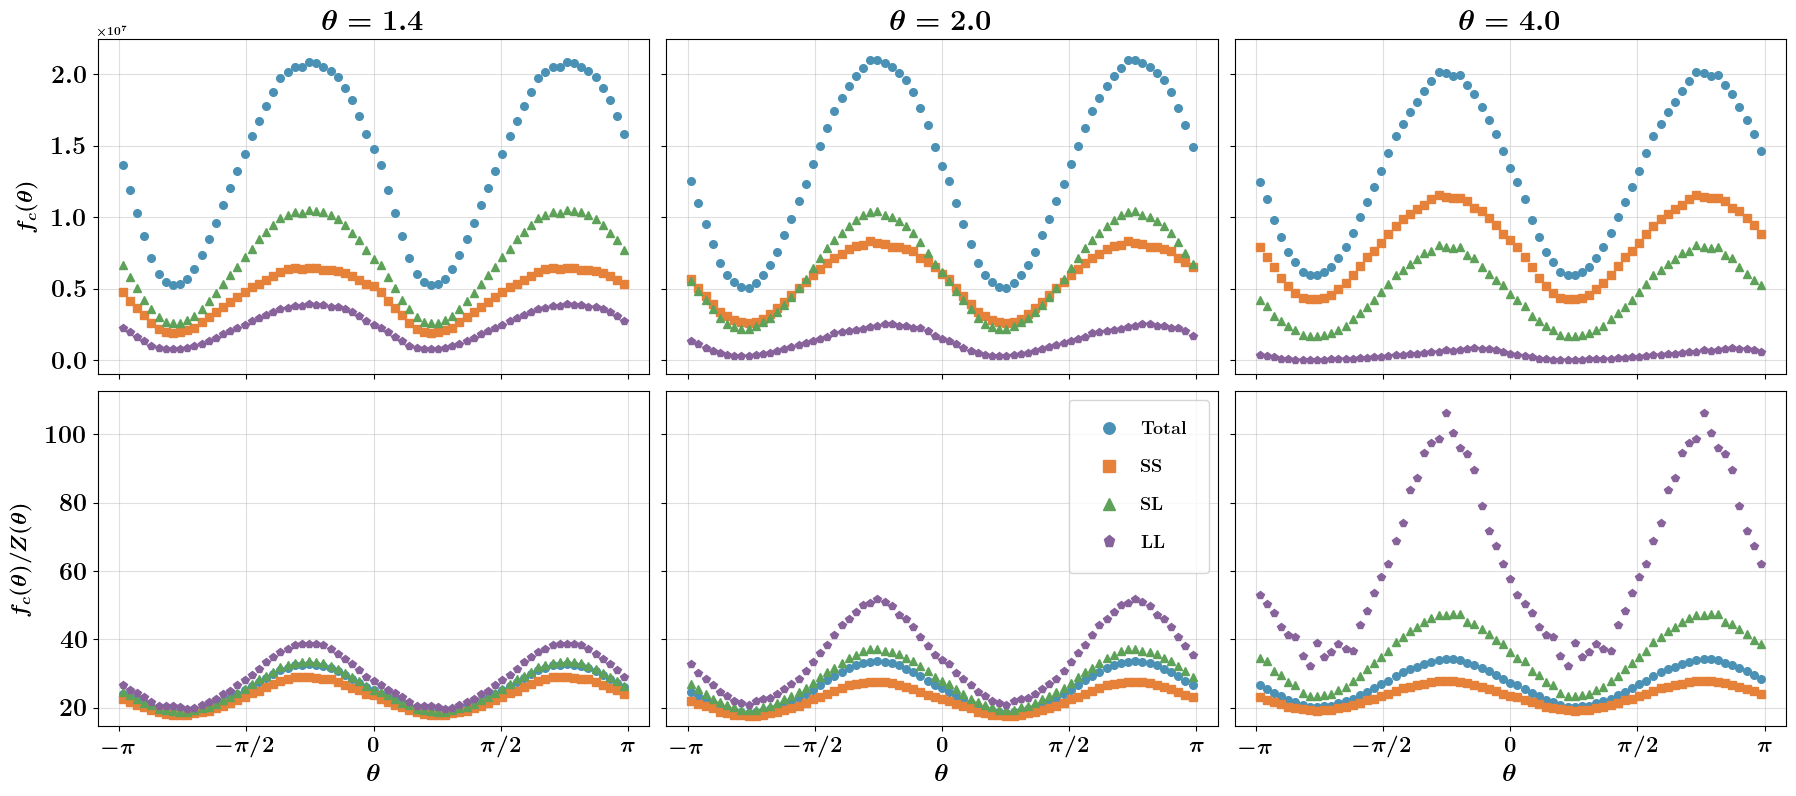

In [72]:
# plot 1

plt.clf()

topDir        = '/media/rahul/Rahul_2TB/high_bidispersity'
fig_save_path = '/media/Linux_1TB/City College Dropbox/Rahul Pandare/CUNY/Research/Bidisperse Project/analysis/figures/angular_plots/angular_Force/'

ranSeedFile = "random_seed.dat"
intFile     = "int_random_seed_params_stress100r_shear.dat"
contFile    = 'contacts.txt'

npp  = 1000 # no. of particles
off  = 100  # steady state cut off
runs = 4
angleBins  = np.linspace(-np.pi, np.pi,72)
binCenters = (angleBins[:-1] + angleBins[1:])/2

phii = 0.75
ar   = [1.4, 2.0, 4.0]

sizePair     = ['Total', 'SS', 'SL', 'LL']
line_markers = ['o', 's', '^', 'p']
colors       = ['#4a91b5', '#e68139', '#5da258', '#87629b', '#1b9e77']
linestyles   = ['None', 'None', 'None', 'None']
plotType     = [r'$f_c(\theta)$',r'$f_c(\theta)/Z(\theta)$']

fig, axs = plt.subplots(len(plotType), len(ar), figsize=(6*len(ar), 4*len(plotType)))

for j, arj in enumerate(ar):
    phir = '{:.3f}'.format(phii) if len(str(phii).split('.')[1])>2 else '{:.2f}'.format(phii)
    if arj == 4.0: phir ='0.78'
    dataname     = topDir + '/NP_' + str(npp) + '/phi_' + phir + '/ar_' + str(arj) + '/Vr_0.5'

    forceBin_Sum = [[0]*len(binCenters) for _ in range(len(sizePair))] # empty nested list for all four runs 
    contList_Sum = [[0]*len(binCenters) for _ in range(len(sizePair))]
    contCount    = [0]*len(sizePair)

    if os.path.exists(dataname):
        for l in range (runs):
            ranFile      = open(f'{dataname}/run_{l+1}/{ranSeedFile}', 'r')
            particleSize = particleSizeList(ranFile, sizeRatio = arj) 
    
            interFile = open(f'{dataname}/run_{l+1}/{intFile}', 'r')
            intList   = interactionsList(interFile) 
           
            for sampleList in intList[off:]:
                for i in range (sampleList.shape[0]):
                    particleSize1 = particleSize[int(sampleList[i,0])]
                    particleSize2 = particleSize[int(sampleList[i,1])]
                    contState     = int(sampleList[i,10]) # Contact state
                    contForce     = sampleList[i,11] # Norm of normal contact force
                    thetaRad      = np.arctan2(sampleList[i,4], sampleList[i,2])
    
                    if contState == 2:
                        # For all particles.
                        updateContForce(thetaRad, binCenters, forceBin_Sum[0], contList_Sum[0], contForce)
                        contCount[0] += 2
                        
                        # Small-Small.
                        if (particleSize1 == particleSize2 == 1):
                            updateContForce(thetaRad, binCenters, forceBin_Sum[1], contList_Sum[1], contForce)
                            contCount[1] += 2
    
                        # Small-Large
                        elif (particleSize1 != particleSize2):
                            updateContForce(thetaRad, binCenters, forceBin_Sum[2], contList_Sum[2], contForce)
                            contCount[2] += 2
    
                        # Large-Large
                        elif (particleSize1 == particleSize2 > 1):
                            updateContForce(thetaRad, binCenters, forceBin_Sum[3], contList_Sum[3], contForce)
                            contCount[3] += 2

    print(f'{[np.round(np.sum(a)/np.sum(contList_Sum[3])) for a in contList_Sum]} \n')
    for ii in range(len(forceBin_Sum)):
        forceDensity1 = forceBin_Sum[ii]
        forceDensity2 = [i/k for i,k in zip(forceBin_Sum[ii],contList_Sum[ii])]
        forceDensity1[35] *= 2
        axs[0,j].plot(binCenters, forceDensity1, linestyle=linestyles[ii], 
                marker=line_markers[ii], markersize=5.5, color=colors[ii])
        axs[1,j].plot(binCenters, forceDensity2, linestyle=linestyles[ii], 
                label=fr'\textbf{{{sizePair[ii]}}}',marker=line_markers[ii], 
                      markersize=5.5, color=colors[ii])

xticks       = [-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi]
xtick_labels = [r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$']
for kk in range(len(plotType)):
    y_mins = [ax.get_ylim()[0] for ax in axs[kk, :]]
    y_maxs = [ax.get_ylim()[1] for ax in axs[kk, :]]
    min_y, max_y = min(y_mins) * 0.98, max(y_maxs) * 1.02
    
    for ax in axs[kk,:]:
        ax.set_ylim(min_y, max_y)
        ax.set_yticks(ax.get_yticks()[(ax.get_yticks() >= min_y) & (ax.get_yticks() <= max_y)])
        #print(min(y_mins), max(y_maxs))
        
    for j, arj in enumerate(ar):
        axs[kk,j].grid(True, alpha=0.4, axis='both', which='both')
        axs[1,j].set_xticks(xticks)
        axs[1,j].set_xticklabels(xtick_labels, fontsize=16)
        axs[0,j].set_xticks(xticks)
        axs[0,j].set_xticklabels([])
        axs[1,j].set_xlabel(r'$\theta$', fontsize=18)
        axs[0,j].set_title(fr'$\theta = {arj}$', fontsize=21)
        if j == 0:
            axs[kk,j].tick_params(axis='y', labelsize=18)
            axs[kk,j].set_ylabel(plotType[kk], fontsize=16, labelpad=10)
        else:
            axs[kk,j].tick_params(axis='y', which='both', left=True, right=False, labelleft=False)
            
axs[1, 1].legend(loc='best', fontsize=13, labelspacing=1.2,borderpad=1.2, markerscale=1.5)

plt.tight_layout()
if True:
    figFormat     = ".svg"
    plt.savefig(fig_save_path + '/angularForcesAllSizePair_both1_NP_' + str(npp) + figFormat, bbox_inches = "tight", dpi = 500)

plt.show()

[7.0, 2.0, 3.0, 1.0] 

[14.0, 7.0, 6.0, 1.0] 

[99.0, 71.0, 27.0, 1.0] 



/tmp/ipykernel_341345/3170104359.py:103: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1,j].set_xticklabels(xtick_labels, fontsize=16)
/tmp/ipykernel_341345/3170104359.py:103: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1,j].set_xticklabels(xtick_labels, fontsize=16)
/tmp/ipykernel_341345/3170104359.py:103: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axs[1,j].set_xticklabels(xtick_labels, fontsize=16)


<Figure size 640x480 with 0 Axes>

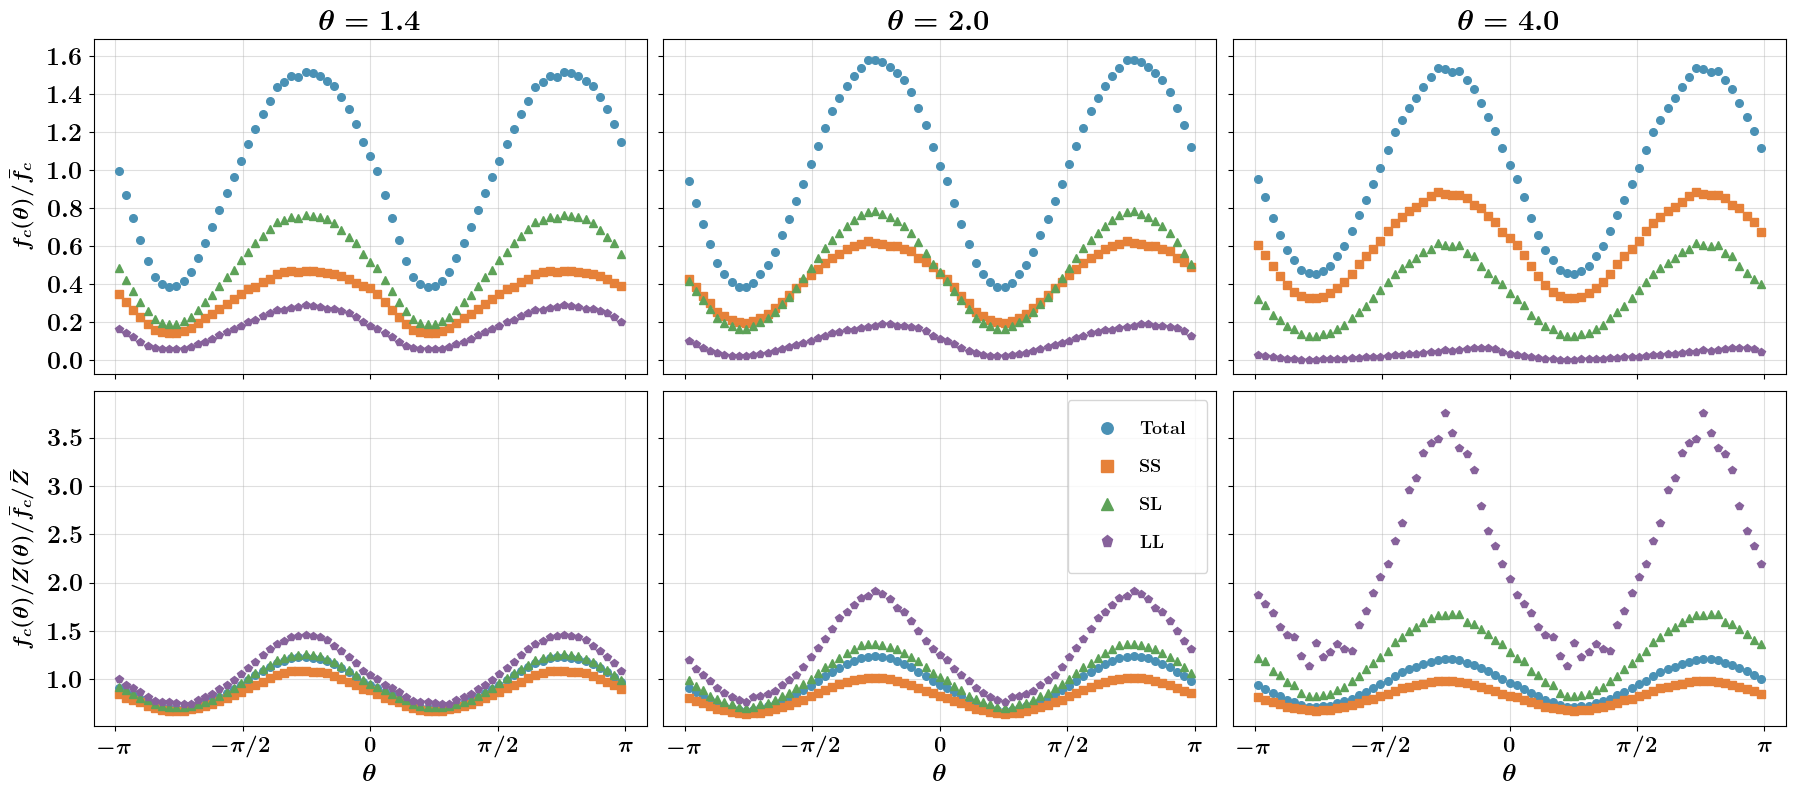

In [75]:
# plot 2 (with normalization)
from matplotlib.ticker import FixedLocator
plt.clf()

topDir        = '/media/rahul/Rahul_2TB/high_bidispersity'
fig_save_path = '/media/Linux_1TB/City College Dropbox/Rahul Pandare/CUNY/Research/Bidisperse Project/analysis/figures/angular_plots/angular_Force/'

ranSeedFile = "random_seed.dat"
intFile     = "int_random_seed_params_stress100r_shear.dat"
contFile    = 'contacts.txt'

npp  = 1000 # no. of particles
off  = 100  # steady state cut off
runs = 4
angleBins  = np.linspace(-np.pi, np.pi,72)
binCenters = (angleBins[:-1] + angleBins[1:])/2

phii = 0.75
ar   = [1.4, 2.0, 4.0]

sizePair     = ['Total', 'SS', 'SL', 'LL']
line_markers = ['o', 's', '^', 'p']
colors       = ['#4a91b5', '#e68139', '#5da258', '#87629b', '#1b9e77']
linestyles   = ['None', 'None', 'None', 'None']
plotType     = [r'$f_c(\theta)/\bar{f_{c}}$',r'$f_c(\theta)/Z(\theta)/\bar{f_{c}}/\bar{Z}$']

fig, axs = plt.subplots(len(plotType), len(ar), figsize=(6*len(ar), 4*len(plotType)))

for j, arj in enumerate(ar):
    phir = '{:.3f}'.format(phii) if len(str(phii).split('.')[1])>2 else '{:.2f}'.format(phii)
    if arj == 4.0: phir ='0.78'
    dataname     = topDir + '/NP_' + str(npp) + '/phi_' + phir + '/ar_' + str(arj) + '/Vr_0.5'

    forceBin_Sum = [[0]*len(binCenters) for _ in range(len(sizePair))] # empty nested list for all four runs 
    contList_Sum = [[0]*len(binCenters) for _ in range(len(sizePair))]
    contCount    = [0]*len(sizePair)

    if os.path.exists(dataname):
        for l in range (runs):
            ranFile      = open(f'{dataname}/run_{l+1}/{ranSeedFile}', 'r')
            particleSize = particleSizeList(ranFile, sizeRatio = arj) 
    
            interFile   = open(f'{dataname}/run_{l+1}/{intFile}', 'r')
            contactList = interactionsList(interFile) 
           
            for sampleList in contactList[off:]:
                for i in range (sampleList.shape[0]):
                    particleSize1 = particleSize[int(sampleList[i,0])]
                    particleSize2 = particleSize[int(sampleList[i,1])]
                    contState     = int(sampleList[i,10]) # Contact state
                    contForce     = sampleList[i,11] # Norm of normal contact force
                    thetaRad      = np.arctan2(sampleList[i,4], sampleList[i,2])
    
                    if contState == 2:
                        # For all particles.
                        updateContForce(thetaRad, binCenters, forceBin_Sum[0], contList_Sum[0], contForce)
                        contCount[0] += 2
                        
                        # Small-Small.
                        if (particleSize1 == particleSize2 == 1):
                            updateContForce(thetaRad, binCenters, forceBin_Sum[1], contList_Sum[1], contForce)
                            contCount[1] += 2
    
                        # Small-Large
                        elif (particleSize1 != particleSize2):
                            updateContForce(thetaRad, binCenters, forceBin_Sum[2], contList_Sum[2], contForce)
                            contCount[2] += 2
    
                        # Large-Large
                        elif (particleSize1 == particleSize2 > 1):
                            updateContForce(thetaRad, binCenters, forceBin_Sum[3], contList_Sum[3], contForce)
                            contCount[3] += 2
                            
    forceAvg = np.mean(forceBin_Sum[0])
    contAvg  = np.mean(contList_Sum[0])
    
    print(f'{[np.round(np.sum(a)/np.sum(contList_Sum[3])) for a in contList_Sum]} \n')
    for ii in range(len(forceBin_Sum)):
        forceDensity1 = [i/forceAvg for i in forceBin_Sum[ii]]
        forceDensity2 = [(i/k)/(forceAvg/contAvg) for i,k in zip(forceBin_Sum[ii],contList_Sum[ii])]
        forceDensity1[35] *= 2
        axs[0,j].plot(binCenters, forceDensity1, linestyle=linestyles[ii], 
                marker=line_markers[ii], markersize=5.5, color=colors[ii])
        axs[1,j].plot(binCenters, forceDensity2, linestyle=linestyles[ii], 
                label=fr'\textbf{{{sizePair[ii]}}}',marker=line_markers[ii], 
                      markersize=5.5, color=colors[ii])
        
xticks       = [-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi]
xtick_labels = [r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$']
for kk in range(len(plotType)):
    y_mins = [ax.get_ylim()[0] for ax in axs[kk, :]]
    y_maxs = [ax.get_ylim()[1] for ax in axs[kk, :]]
    min_y, max_y = min(y_mins) * 0.98, max(y_maxs) * 1.02
    
    for ax in axs[kk,:]:
        ax.set_ylim(min_y, max_y)
        ax.set_yticks(ax.get_yticks()[(ax.get_yticks() >= min_y) & (ax.get_yticks() <= max_y)])
        #print(min(y_mins), max(y_maxs))
    
    for j, arj in enumerate(ar):
        axs[kk,j].grid(True, alpha=0.4, axis='both', which='both')
        axs[1,j].set_xticks(xticks)
        axs[1,j].set_xticklabels(xtick_labels, fontsize=16)
        axs[0,j].set_xticks(xticks)
        axs[0,j].set_xticklabels([])
        axs[1,j].set_xlabel(r'$\theta$', fontsize=18)
        axs[0,j].set_title(fr'$\theta = {arj}$', fontsize=21)
        if j == 0:
            axs[kk,j].tick_params(axis='y', labelsize=18)
            axs[kk,j].set_ylabel(plotType[kk], fontsize=16, labelpad=10)
        else:
            axs[kk,j].tick_params(axis='y', which='both', left=True, right=False, labelleft=False)
        
axs[1, 1].legend(loc='best', fontsize=13, labelspacing=1.2,borderpad=1.2, markerscale=1.5)

plt.tight_layout()
if True:
    figFormat     = ".svg"
    plt.savefig(fig_save_path + '/angularForcesAllSizePair_both2_NP_' + str(npp) + figFormat, bbox_inches = "tight", dpi = 500)

plt.show()

[6.0, 2.0, 3.0, 1.0] 

[13.0, 7.0, 6.0, 1.0] 

[121.0, 86.0, 34.0, 1.0] 



<Figure size 640x480 with 0 Axes>

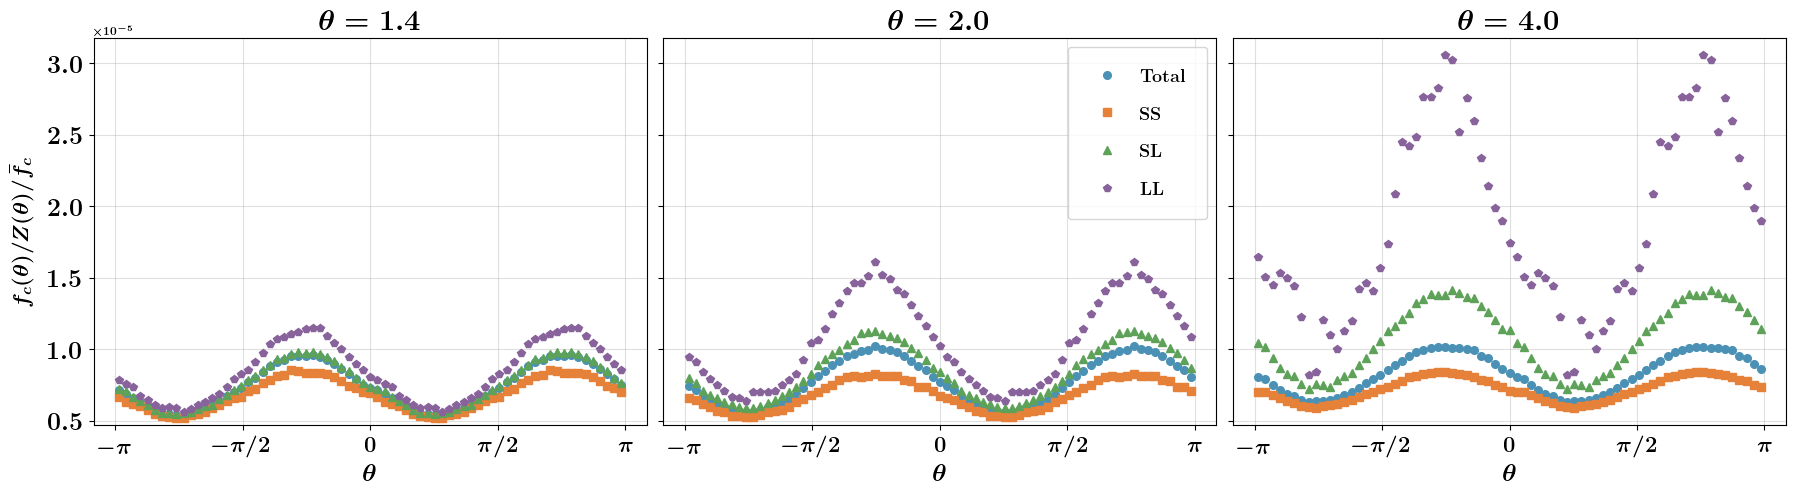

In [47]:
plt.clf()

topDir        = '/media/rahul/Rahul_2TB/high_bidispersity'
fig_save_path = '/media/Linux_1TB/City College Dropbox/Rahul Pandare/CUNY/Research/Bidisperse Project/analysis/figures/angular_plots/angular_Force/'

ranSeedFile = "random_seed.dat"
intFile     = "int_random_seed_params_stress100r_shear.dat"
contFile    = 'contacts.txt'

npp  = 1000 # no. of particles
off  = 100  # steady state cut off
runs = 1
angleBins  = np.linspace(-np.pi, np.pi,72)
binCenters = (angleBins[:-1] + angleBins[1:])/2

phii = 0.75
ar   = [1.4, 2.0, 4.0]

sizePair     = ['Total', 'SS', 'SL', 'LL']
line_markers = ['o', 's', '^', 'p']
colors       = ['#4a91b5', '#e68139', '#5da258', '#87629b', '#1b9e77']
linestyles   = ['None', 'None', 'None', 'None']

fig, axs = plt.subplots(1, 3, figsize=(18, 5))
y_mins, y_maxs = [], []
for j, arj in enumerate(ar):
    phir = '{:.3f}'.format(phii) if len(str(phii).split('.')[1])>2 else '{:.2f}'.format(phii)
    if arj == 4.0: phir ='0.79'
    dataname     = topDir + '/NP_' + str(npp) + '/phi_' + phir + '/ar_' + str(arj) + '/Vr_0.5'

    forceBin_Sum = [[0]*len(binCenters) for _ in range(len(sizePair))] # empty nested list for all four runs 
    contList_Sum = [[0]*len(binCenters) for _ in range(len(sizePair))]
    contCount    = [0]*len(sizePair)
    
    if os.path.exists(dataname):
        for l in range (runs):
            # List of particle size. List index is particle index.
            ranFile      = open(f'{dataname}/run_{l+1}/{ranSeedFile}', 'r')
            particleSize = particleSizeList(ranFile, sizeRatio = arj) 
    
            # Nested list of all interaction params, each list is one timestep.
            interFile   = open(f'{dataname}/run_{l+1}/{intFile}', 'r')
            contactList = interactionsList(interFile) 
           
            for sampleList in contactList[off:]:
                for i in range (sampleList.shape[0]):
                    particleSize1 = particleSize[int(sampleList[i,0])]
                    particleSize2 = particleSize[int(sampleList[i,1])]
                    contState     = int(sampleList[i,10]) # Contact state
                    contForce     = sampleList[i,11] # Norm of normal contact force
                    thetaRad      = np.arctan2(sampleList[i,4], sampleList[i,2])
    
                    if contState == 2:
                        # For all particles.
                        updateContForce(thetaRad, binCenters, forceBin_Sum[0], contList_Sum[0], contForce)
                        contCount[0] += 2
                        
                        # Small-Small.
                        if (particleSize1 == particleSize2 == 1):
                            updateContForce(thetaRad, binCenters, forceBin_Sum[1], contList_Sum[1], contForce)
                            contCount[1] += 2
    
                        # Small-Large
                        elif (particleSize1 != particleSize2):
                            updateContForce(thetaRad, binCenters, forceBin_Sum[2], contList_Sum[2], contForce)
                            contCount[2] += 2
    
                        # Large-Large
                        elif (particleSize1 == particleSize2 > 1):
                            updateContForce(thetaRad, binCenters, forceBin_Sum[3], contList_Sum[3], contForce)
                            contCount[3] += 2

    forceAvg = np.mean(forceBin_Sum[0])
    print(f'{[np.round(np.sum(a)/np.sum(contList_Sum[3])) for a in contList_Sum]} \n')
    for ii in range(len(forceBin_Sum)):
        forceDensity = [i/k/forceAvg for i,k in zip(forceBin_Sum[ii],contList_Sum[ii])]
        axs[j].plot(binCenters, forceDensity, linestyle=linestyles[ii], 
                marker=line_markers[ii], markersize=5.5, 
                label=fr'\textbf{{{sizePair[ii]}}}', color=colors[ii])
        axs[j].grid(True, alpha=0.4, axis='both', which='both')

    xticks = [-np.pi, -np.pi / 2, 0, np.pi / 2, np.pi]
    xtick_labels = [r'$-\pi$', r'$-\pi/2$', r'$0$', r'$\pi/2$', r'$\pi$']
    axs[j].set_xticks(xticks)
    axs[j].set_xticklabels(xtick_labels, fontsize=16)
    #axs[j].set_ylim(0.15e-5, 1.25e-5)
    axs[j].set_xlabel(r'$\theta$', fontsize=18)
    axs[j].set_title(fr'$\theta = {arj}$', fontsize=21)
    
    if j == 0:
        axs[j].tick_params(axis='y', labelsize=18)
        axs[j].set_ylabel(r'$f_c(\theta)/Z(\theta)/\bar{f_c}$', fontsize=16, labelpad=10)  # Comment this for 2.0 and 4.0
    else:
        axs[j].tick_params(axis='y', which='both', left=True, right=False, labelleft=False)
        
for i, ax in enumerate(axs):
    y_mins.append(ax.get_ylim()[0])
    y_maxs.append(ax.get_ylim()[1])
for ax in axs:
    ax.set_ylim(min(y_mins), max(y_maxs)) 
    
axs[1].legend(loc='best', fontsize=13, labelspacing=1.2,borderpad=1.2)
plt.tight_layout()
if False:
    figFormat     = ".svg"
    plt.savefig(fig_save_path + '/angularForcesAllSizePair_dividedbycount_NP_' + str(npp) + figFormat, bbox_inches = "tight", dpi = 500)

plt.show()